# DEMO: Creación de un índice en Amazon Kendra

En esta demo se mostrará el procedimiento para implementar de forma sencilla una aplicación RAG utilizando como base los documentos almacenados en un bucket S3 de AWS. El RAG se creará mediante el servicio de AWS "Amazon Kendra".

Este documento está dividido en dos secciones:

- En la primera sección se mostrará, paso a paso, cómo crear el índice a través de la consola de AWS.
- En la segunda sección se detallará la conexión de esta libreta con el índice, permitiendo hacer preguntas a un modelo LLM sobre la información que contienen los documentos almacenados en un bucket S3 de AWS.

## Sección 1: Creación del índice de Kendra

### 1.1 - Acceso al servicio "Amazon Kendra"
Desde la página principal de la consola de AWS, puede utilizar el buscador para encontrar el servicio "Amazon Kendra". Una vez localizado, acceda al servicio.

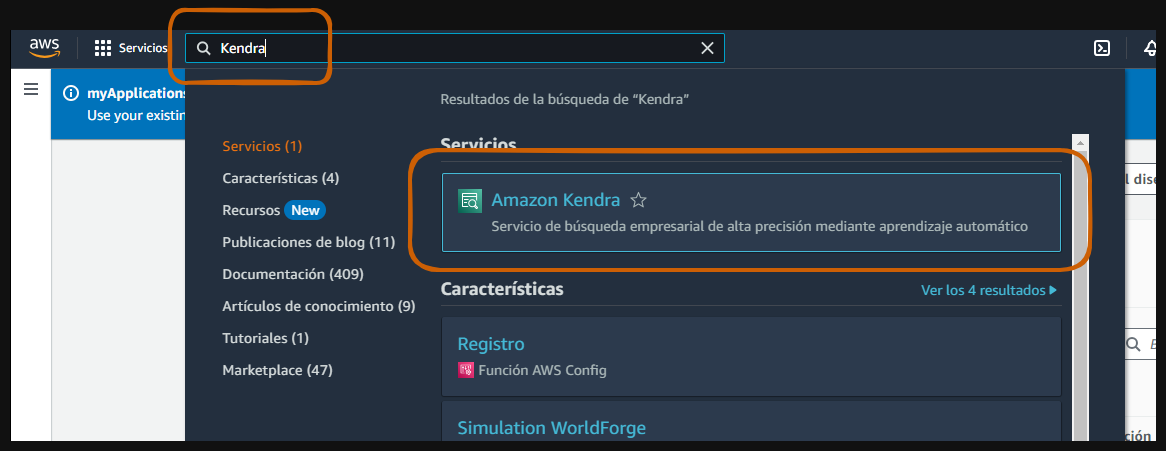

### 1.2 - Creación del índice
En esta página, pulse el botón "create an Index" para ir directamente a la configuración del nuevo índice. 

También puede acceder pulsando el botón (tres rallas) situado a la izquierda de la pantalla. Seguidamente seleccione "Indexes" en el desplegable y, finalmente, pulse "Create Index".

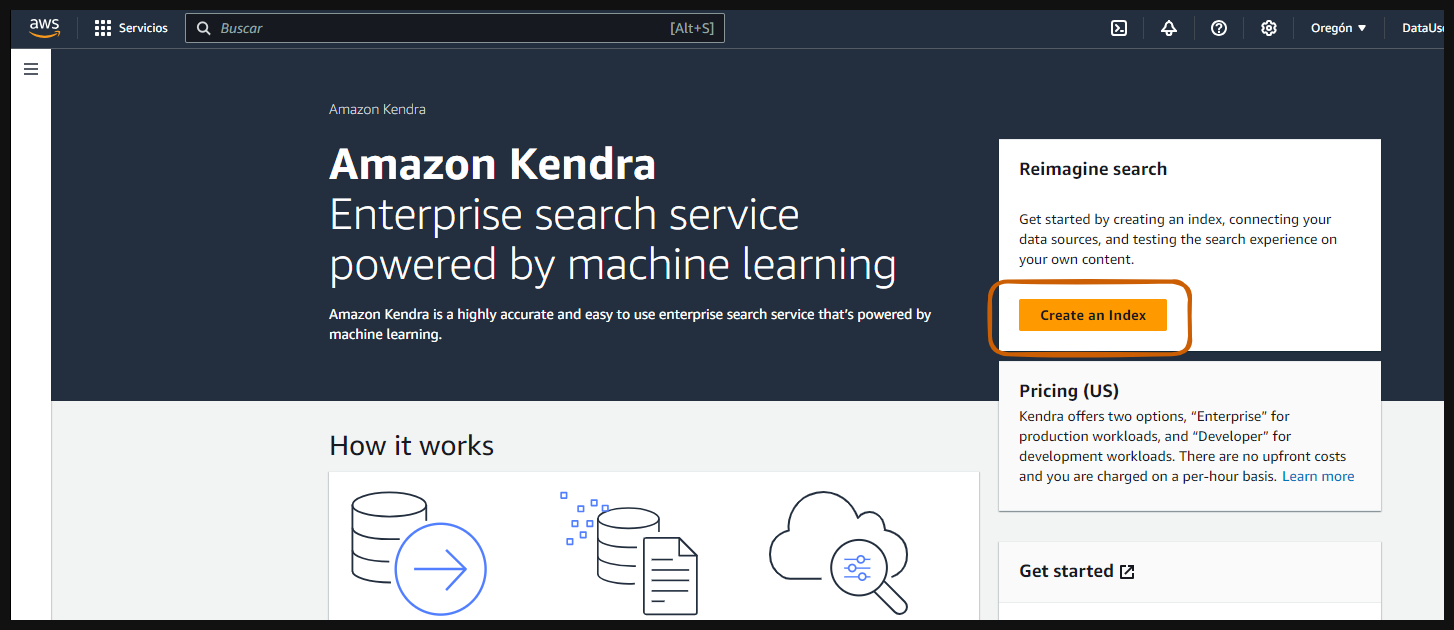

### 1.3 - Configuración general del índice
En primer lugar, se debe dar un nombre al índice y al nuevo rol que se va a crear.  
Una vez dados los nombres deseados, haga clic en el botón de "Siguiente".

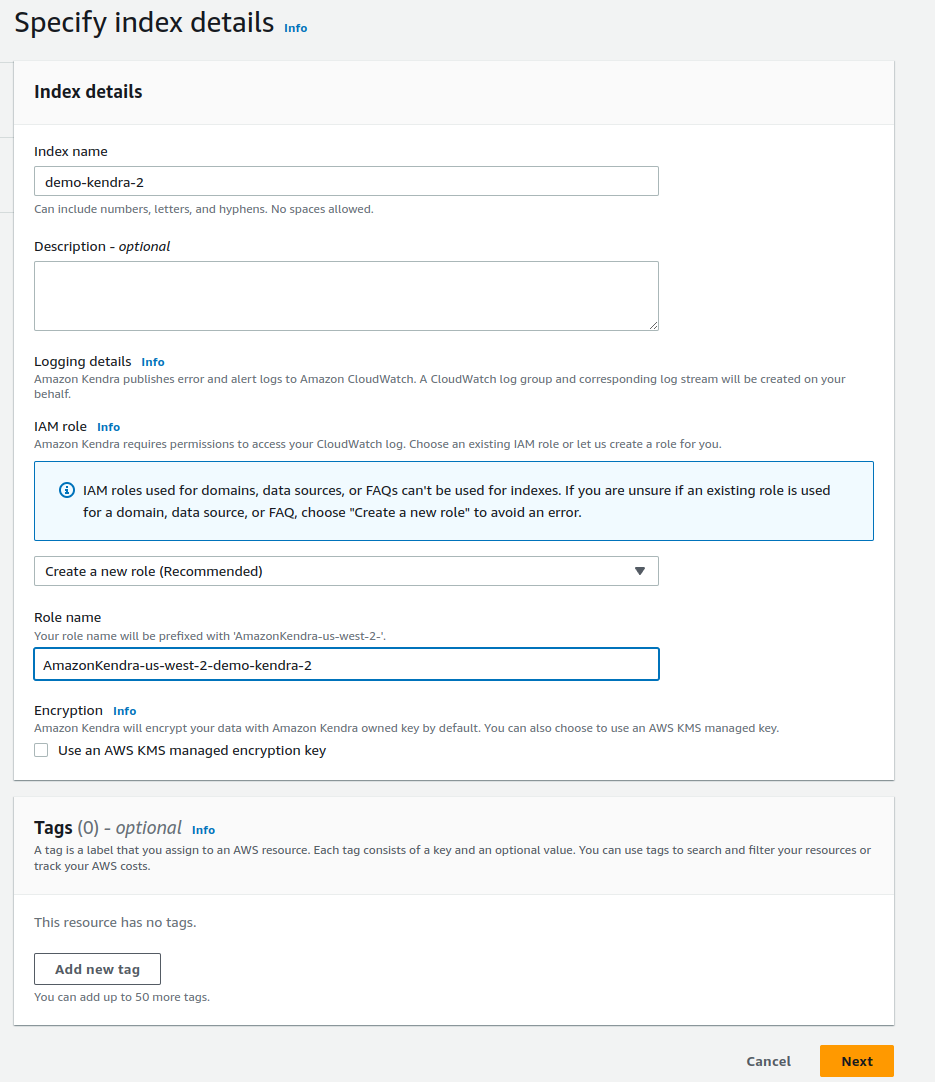

### 1.4 - Configurar el control de acceso
Se debe dejar la configuración del control de acceso por defecto y continuar a la siguiente pantalla.

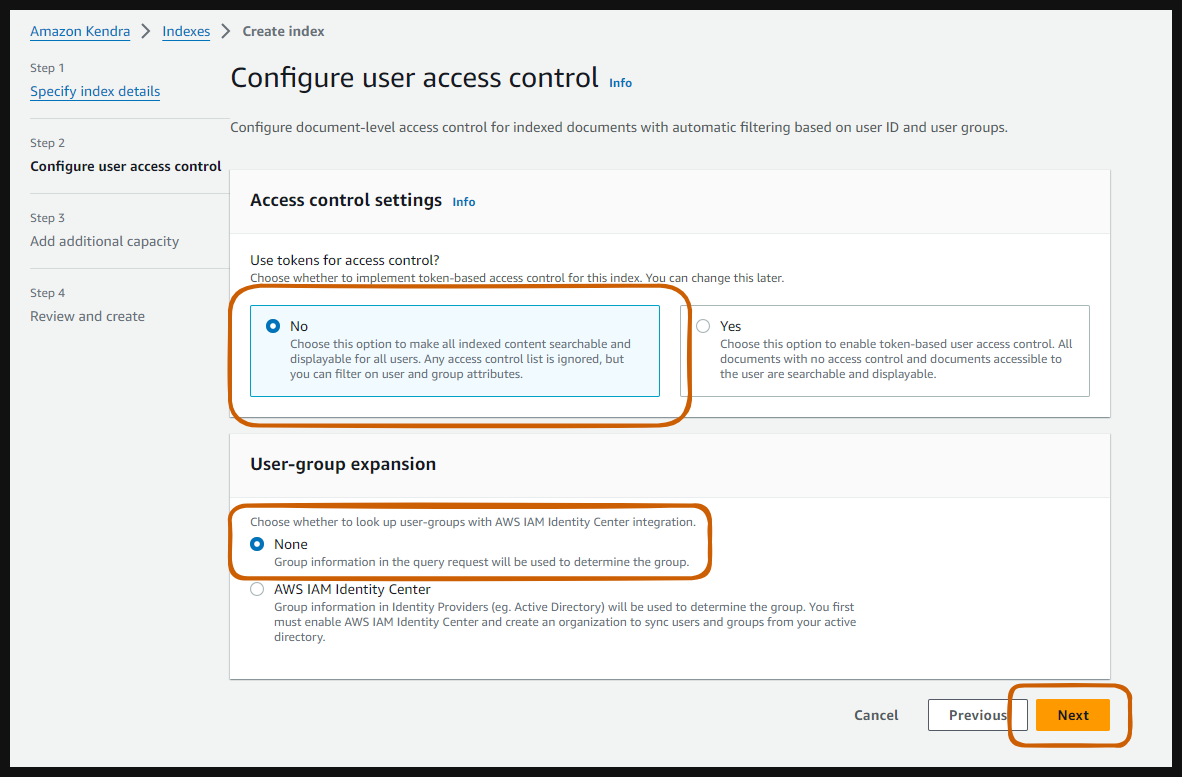

### 1.5 - Seleccionar la edición del índice
En esta pantalla se debe dejar la versión de desarrollo seleccionada, ya que no es necesario un mayor rendimiento para este tutorial.  


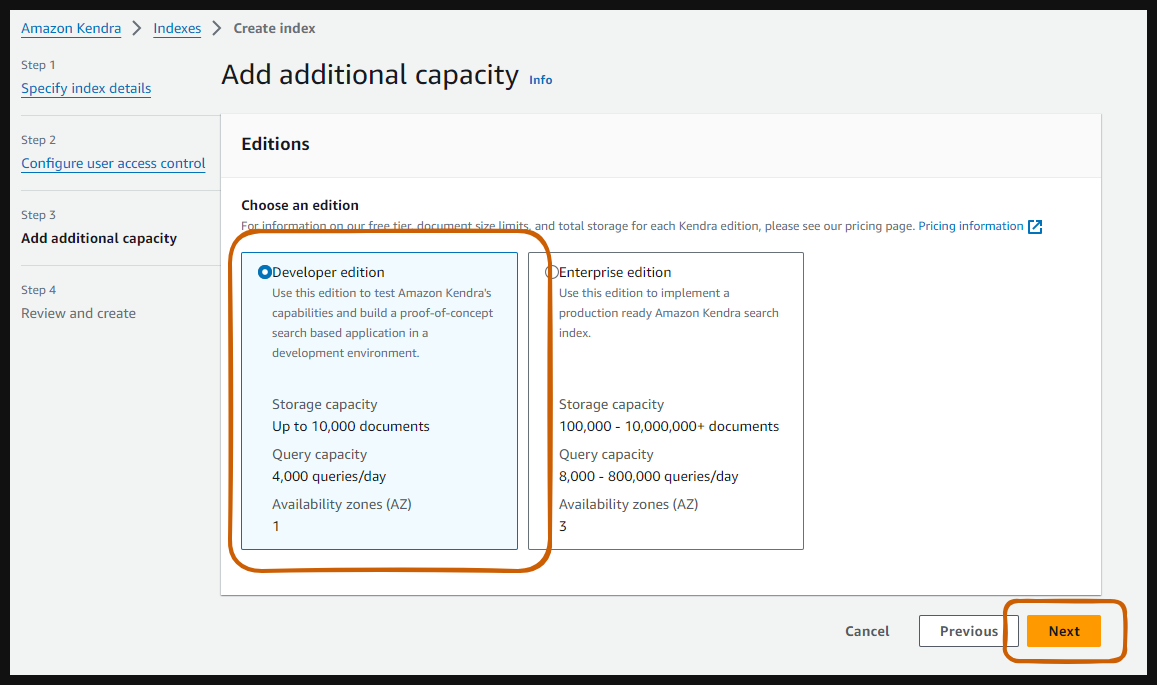

### 1.6 - Revisar y crear el índice
En esta última pantalla se debe comprobar que se hayan seleccionado las opciones anteriormente especificadas. En el caso que todo esté correcto, pulsar "create".

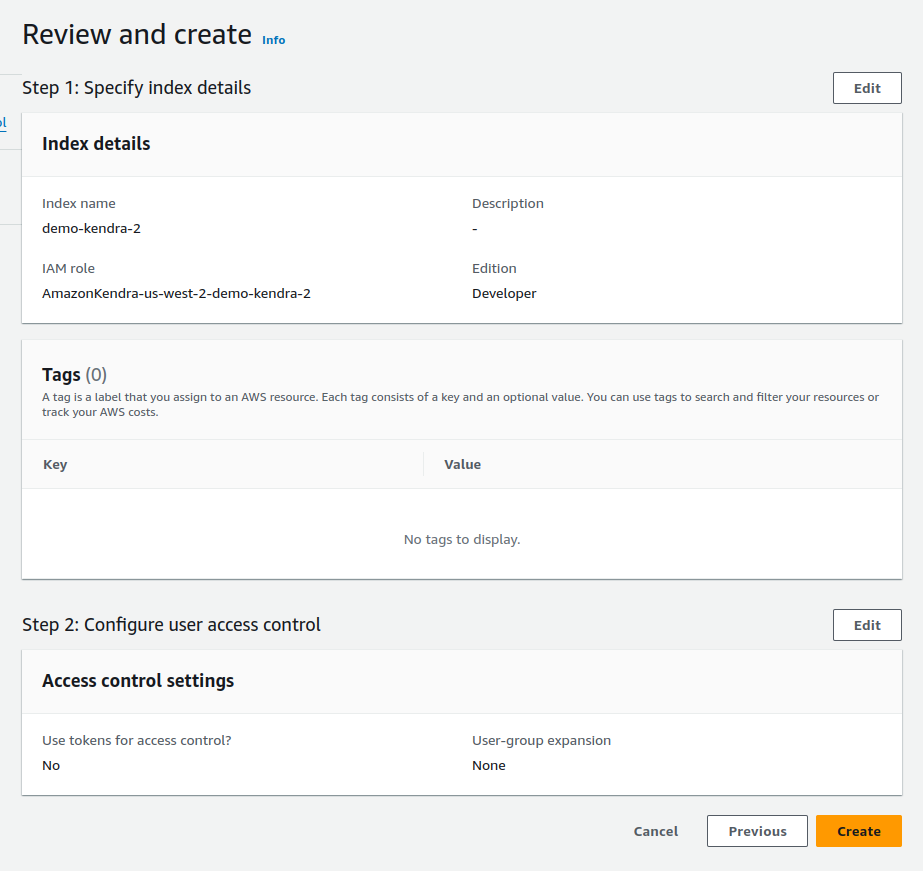

### 1.7 - Comprobación de la creación del índice

Cuando el estado del índice recién creado sea "Active", se puede proceder con el siguiente paso de este tutorial.

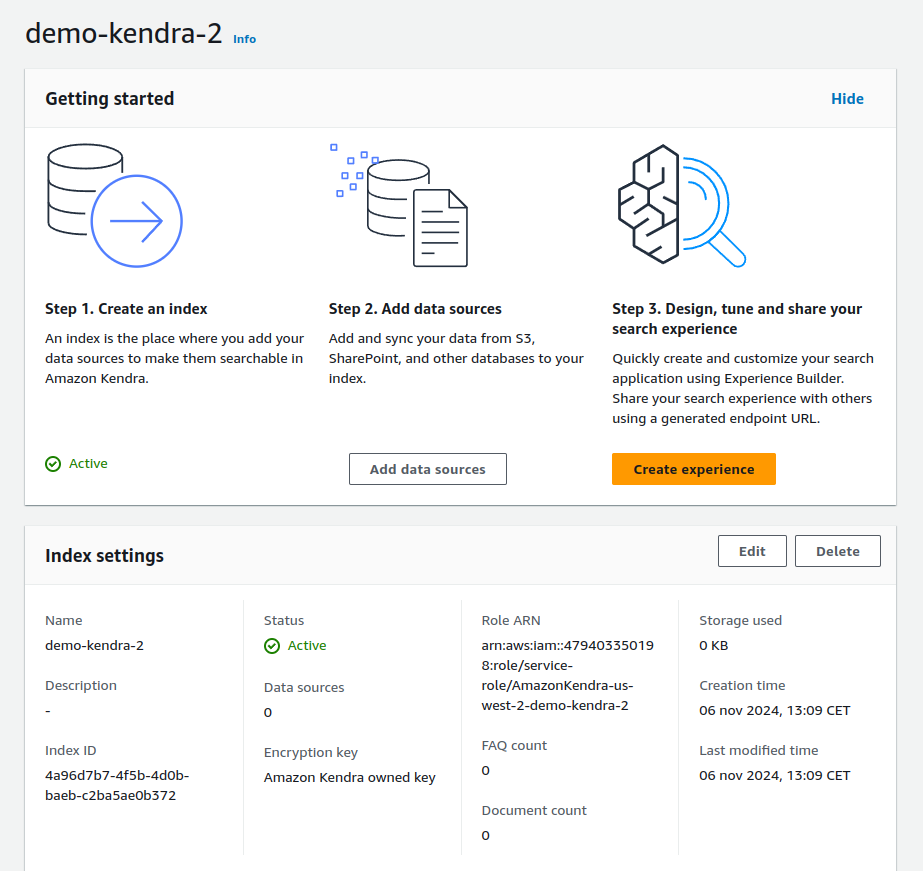

### 1.8 - Creación de la fuente de datos
Se debe añadir una fuente de datos al índice. En este tutorial se muestra cómo añadir un bucket de S3 como fuente de datos.

En primer lugar, pulse "add data source".

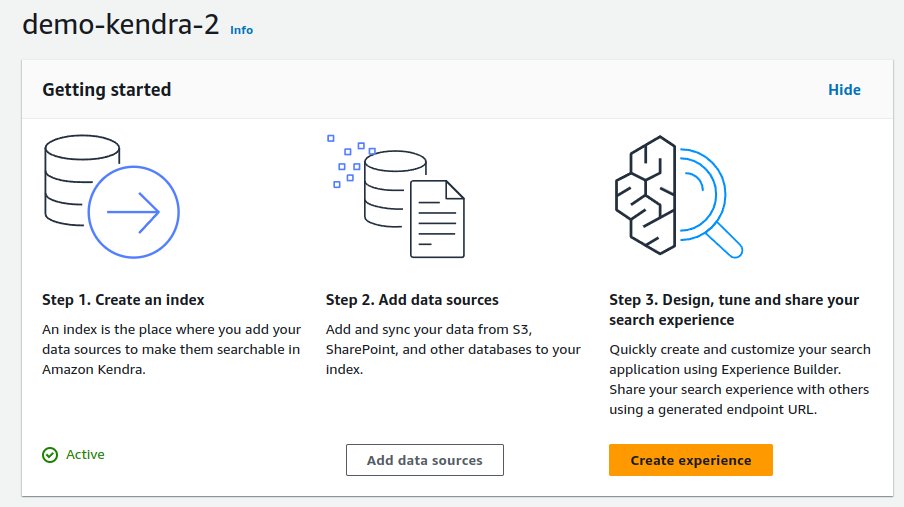

### 1.9 - Selección del tipo de fuente de datos
Se selecciona un bucket de S3 como fuente de datos.  
Se puede usar la herramienta de búsqueda para encontrar la opción fácilmente.

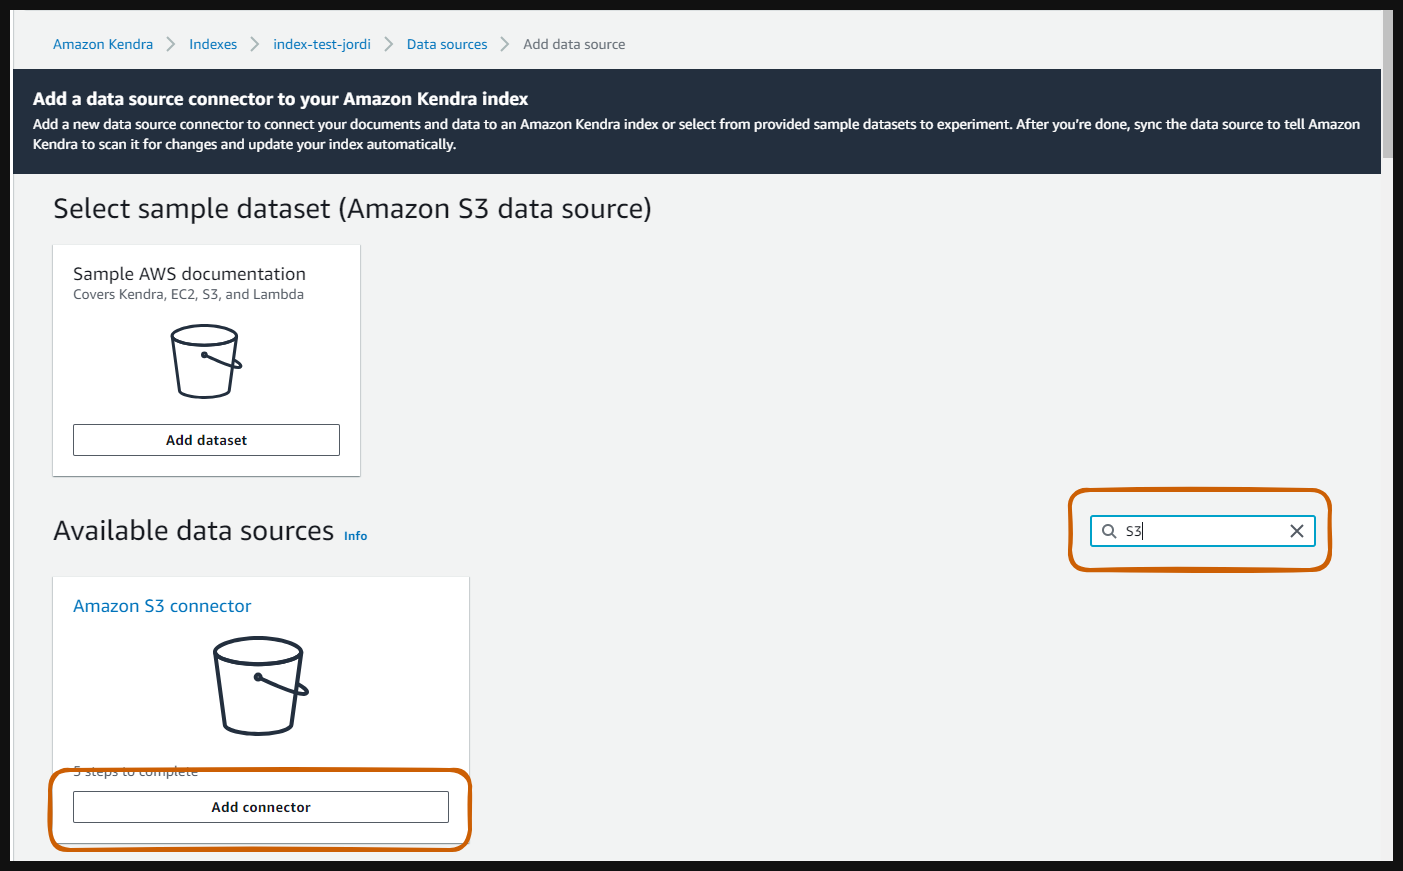

### 1.10 - Nombre e idioma por defecto de la fuente de datos
Se debe dar un nombre a la fuente de datos y también seleccionar el idioma de los documentos que contiene el bucket.

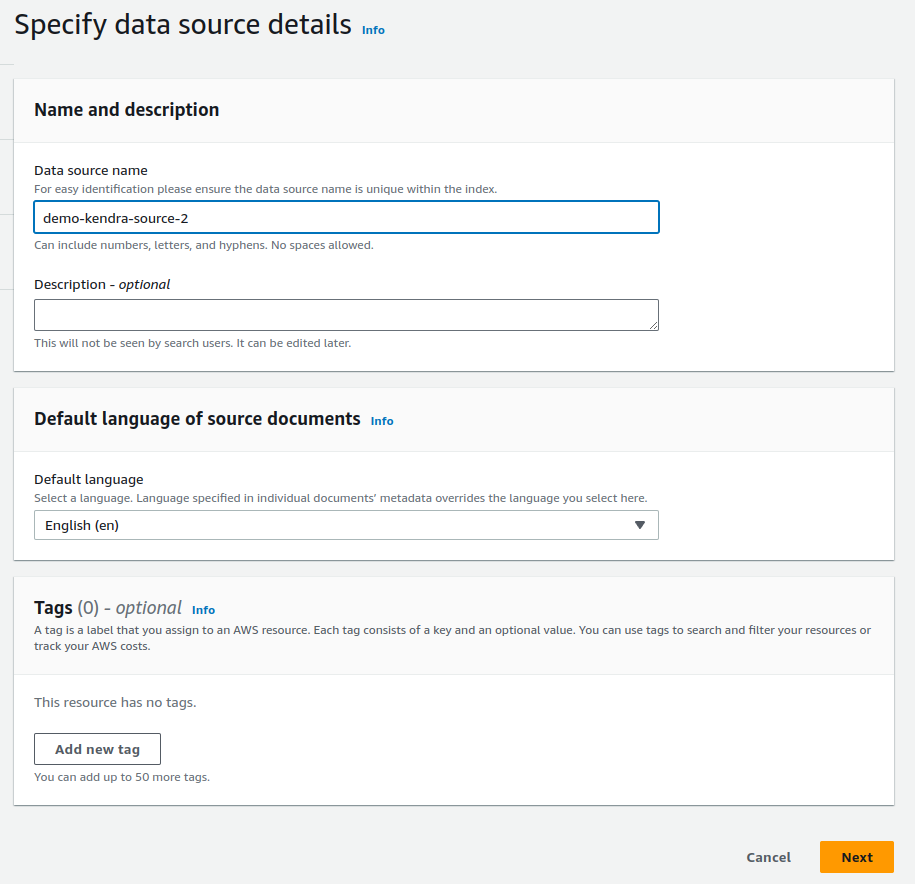

### 1.11 - Nombre del rol
En este paso, se le debe dar un nombre al nuevo rol que se va a crear.

**IMPORTANTE:** crear un nuevo role para cada nueva fuente de datos.

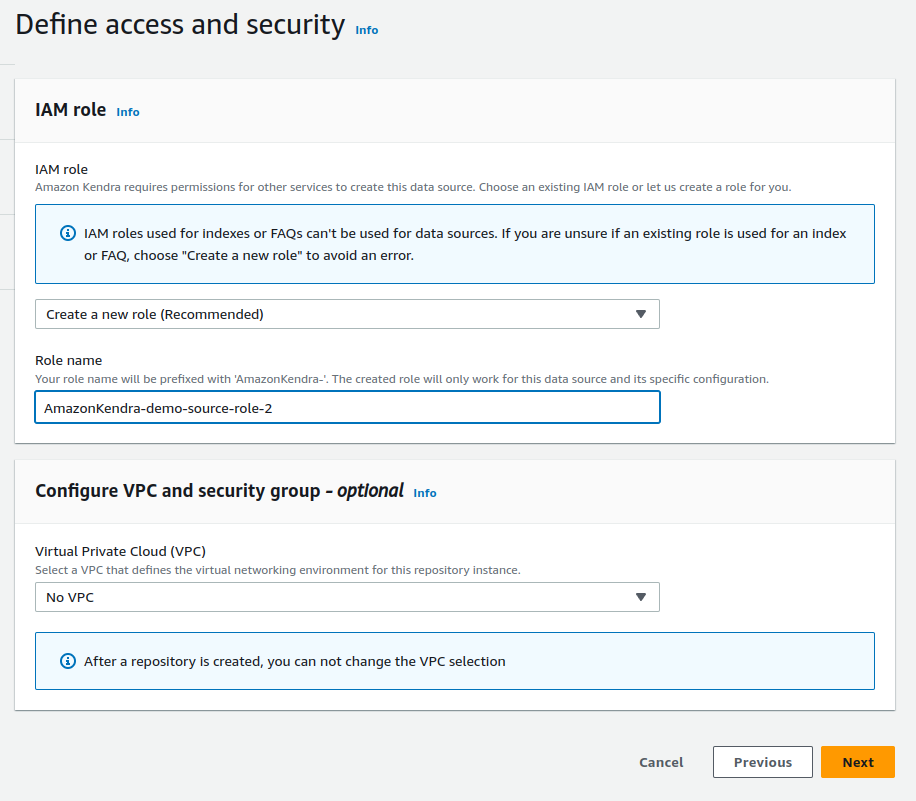

### 1.12 - Configuración de sincronización
A continuación, debe seleccionar el bucket de S3 que contiene los documentos que se usarán para el índice. En esta demo se utilizarán los documentos almacenados en el siguiente bucket:
```
s3://data-clinic-hackathon-2024
```

También, se debe incluir la localización de los documentos dentro del bucket. Esto se especifica en "additional configuration" y dentro de esta "inlude pattern". Para esta demo los ficheros se encuentran en:
```
BASE_DEMO/RAG
```
**IMPORTANTE**: una vez introducido el `path` de pulsar el botón "add" 
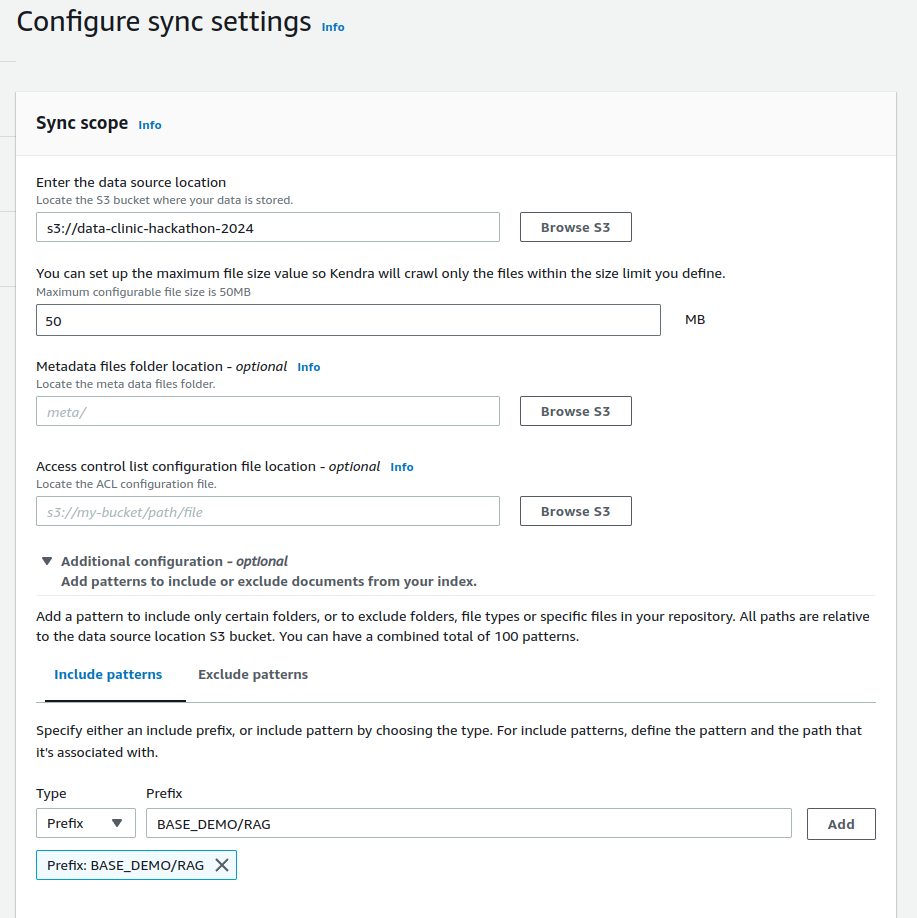

Finalmente, se debe seleccionar la "frecuencia" con la que se va a sincronizar el índice. En este caso, la opción que se debe escoger es "run on demand".


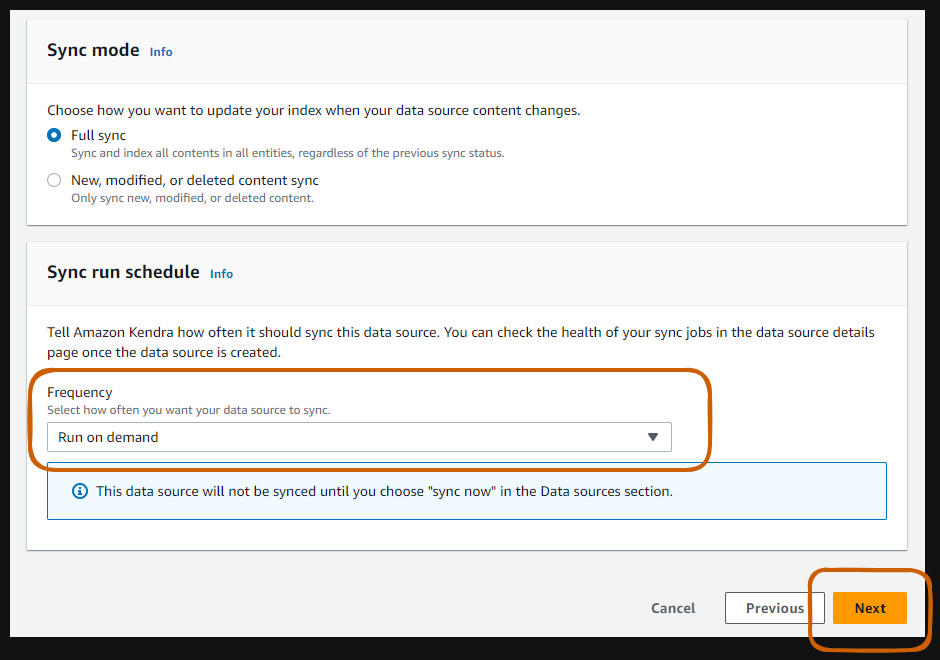

### 1.13 - Mapeo de los campos
En este paso, simplemente se dejan los valores por defecto.

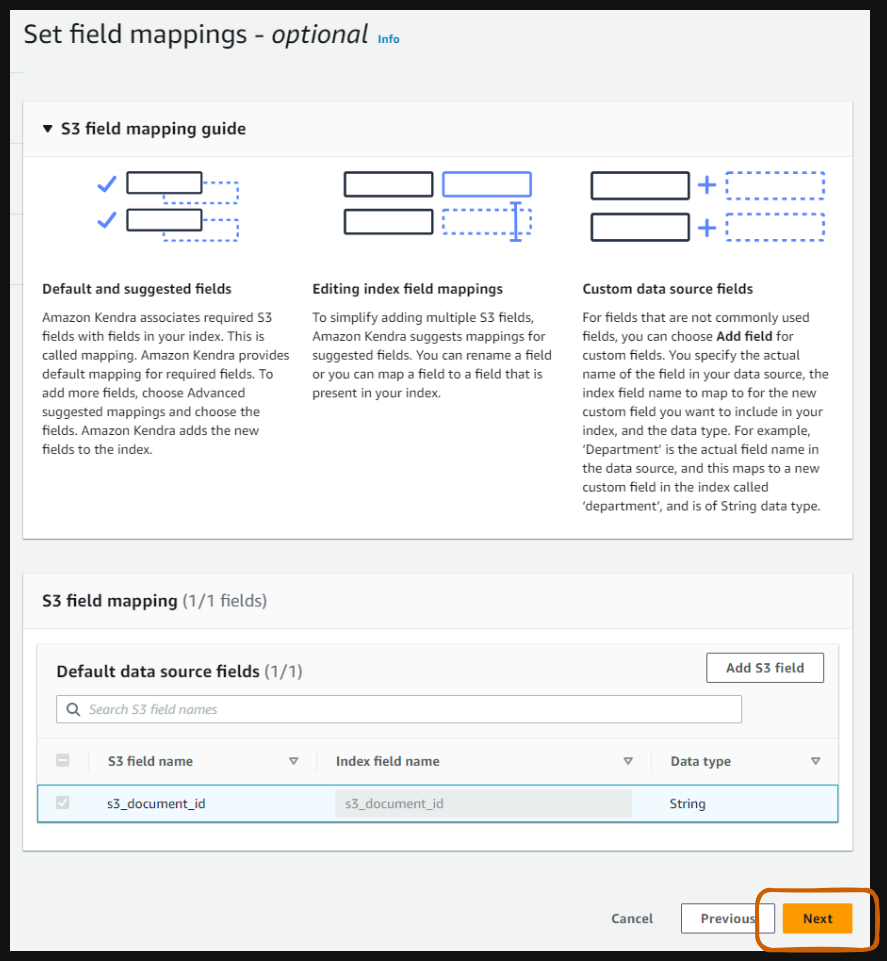

### 1.14 - Creación del índice
En esta pantalla se puede comprobar que todas las opciones sean correctas y, finalmente, se crea el índice.

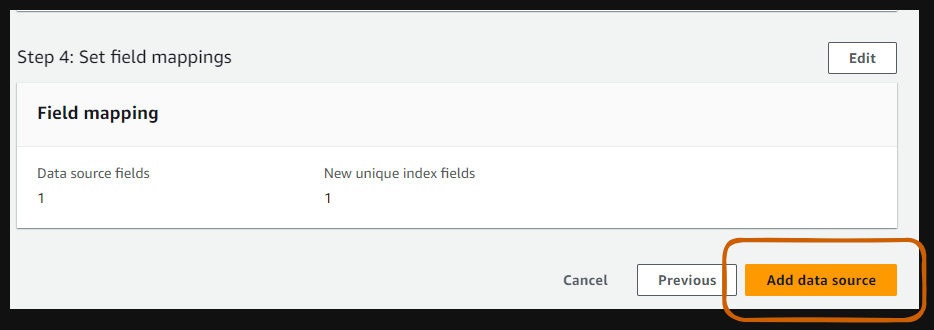

### 1.15 - Comprobación e inicialización de la sincronización
En esta pantalla se comprueba que el índice se haya creado correctamente.  
En caso afirmativo, se debe proceder la sincronización del índice pulsando el botón "sync now".

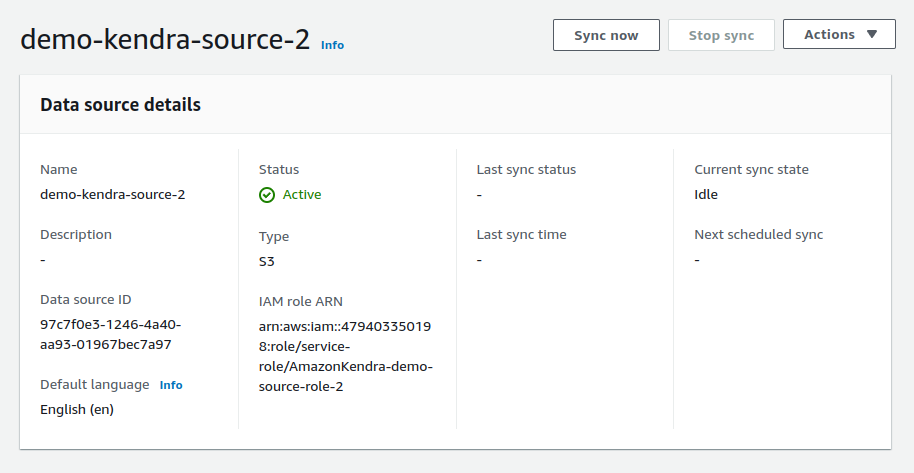

### 1.16 - Comprobación de la sincronización
Se debe esperar un tiempo a que el índice termine la sincronización y una vez finalizado comprobar si todo ha ido bien.

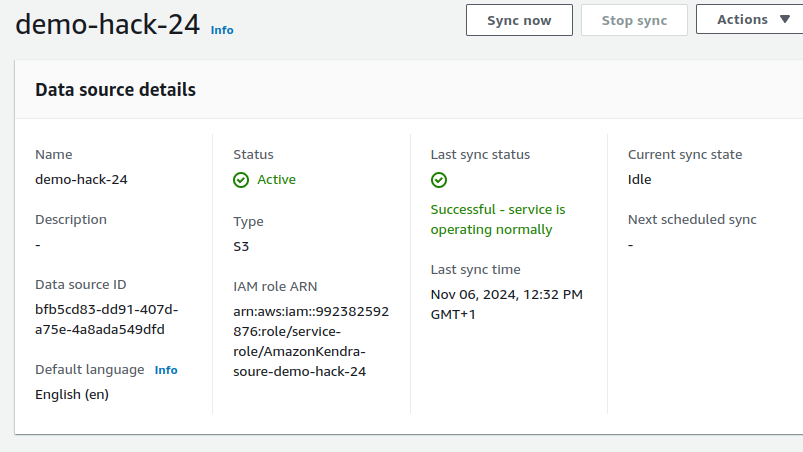

### 1.17 - Copia del ID del índice

En primer lugar, se debe volver a la página de índices. Seguidamente, se selecciona el índice creado y, finalmente, se procede a copiar el ID.

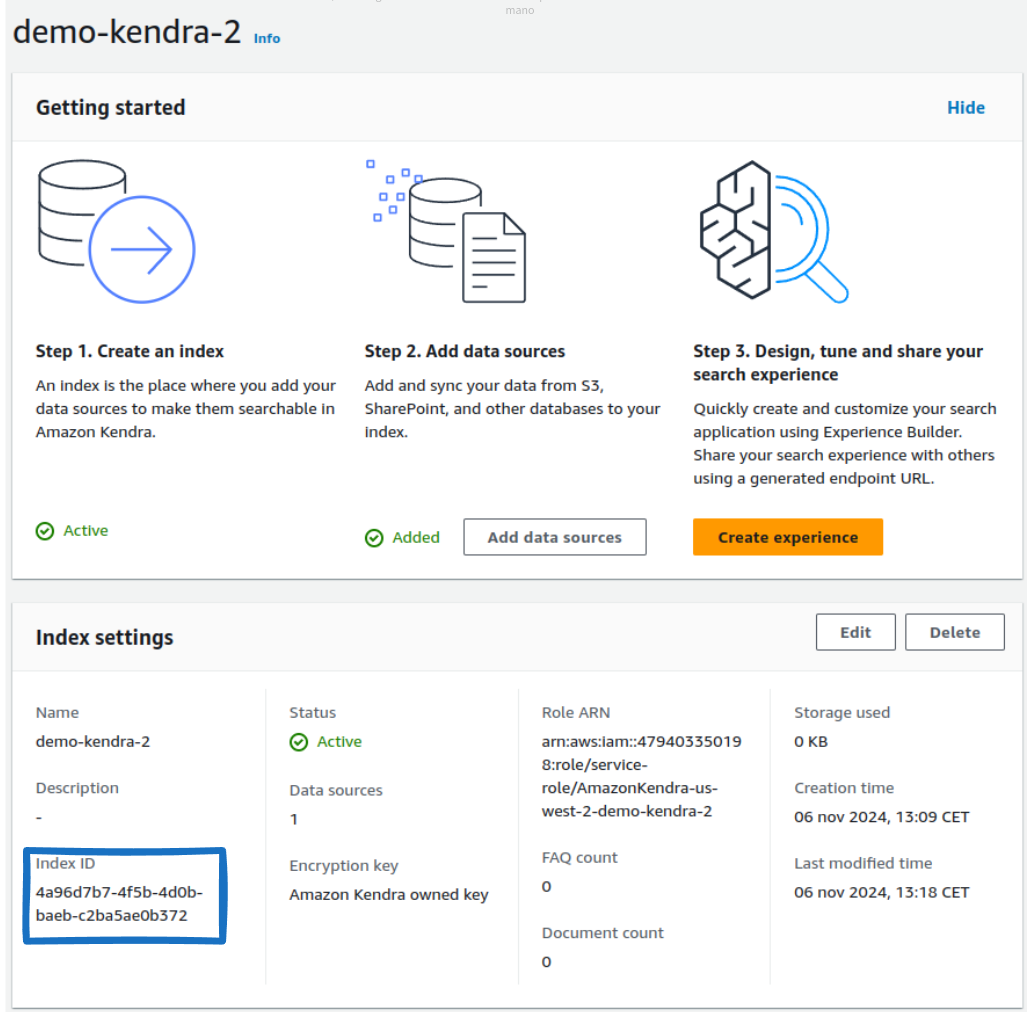

### 1.18. Testeo del índice de Kendra  
En este punto se comprobará si el índice funciona correctamente. Se puede hacer formulando una pregunta o **buscando información que se sabe que está presente en el contenido que se ha subido al bucket** y verificando si se obtiene los resultados esperados. Se puede hacer de dos formas por consola o por código.

- Consola

Acceder a "Search indexed content" en el desplegable situado a la izquierda de la pantalla. Aquí podrá hacer directamente una consulta sobre el contenido de los documentos. En el caso que devuelva algún resultado, se considerará que la creación del índice ha satisfactorio.

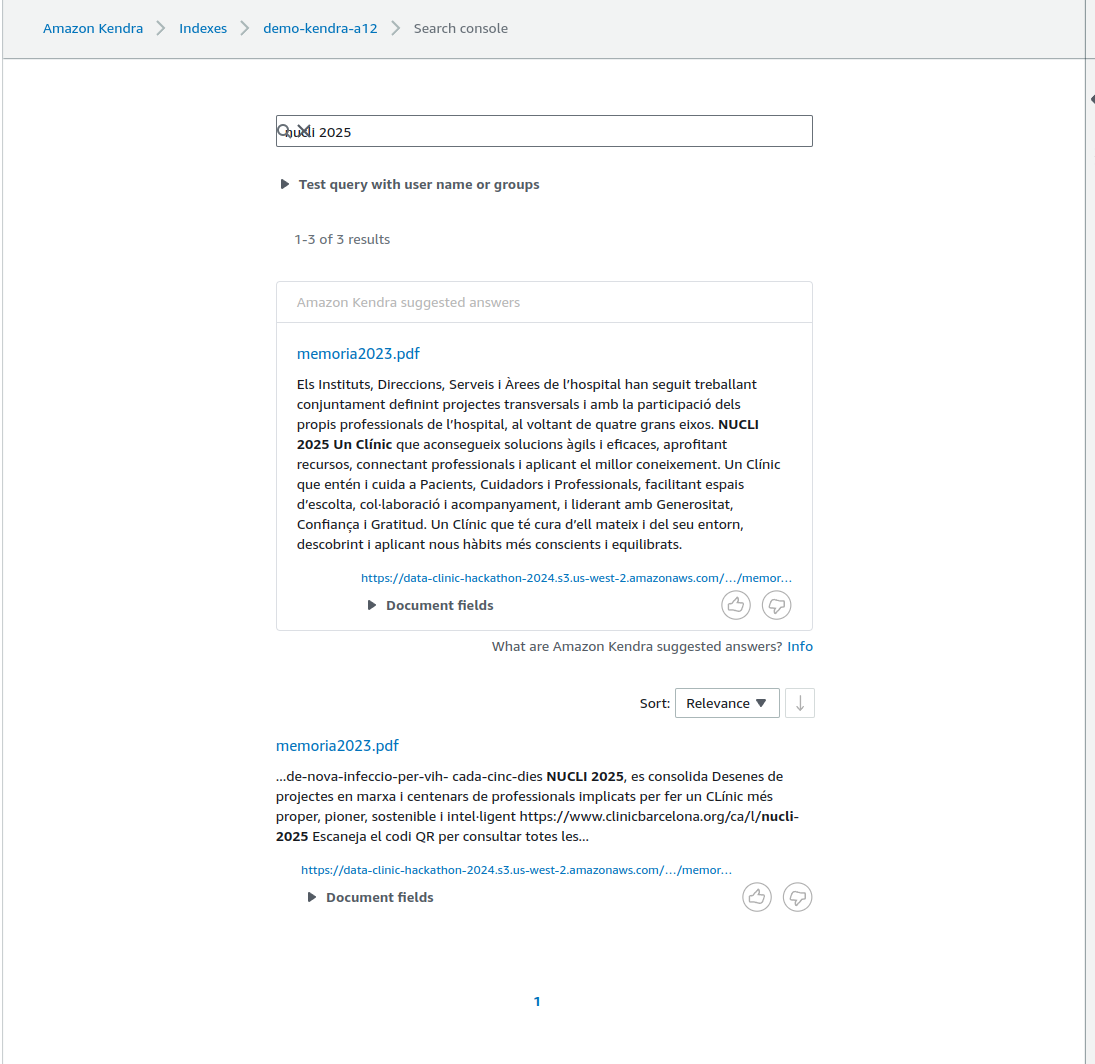



- Código

Ejecutar el código que tiene a continuación:

**NOTA:** recordar cambiar los valores:
- `index_id`: id del índice.
- `query_text` texto que debe sea coherente con el contenido del bucket.

In [ ]:
import boto3
from botocore.exceptions import ClientError

index_id = '######' # Change this!!

kendra_client = boto3.client(
    'kendra',
    region_name="us-west-2"
)

In [ ]:
query_text = 'Què és el nucli 2025?' # Change this question!!

try:
    response = kendra_client.query(
        IndexId=index_id,
        QueryText=query_text
    )
    for result in response['ResultItems']:
        print(f"Type: {result['Type']}")
        print(f"Document Title: {result.get('DocumentTitle', {}).get('Text', 'No title')}")
        print(f"Document URI: {result.get('DocumentURI', 'No URI')}")
        print('---')
except ClientError as e:
    print(f"Error querying index: {e}")

## Sección 2: Uso del índice de Kendra

### 2.1 -  Package import

En este paso se importan las librerías y se crea un cliente para poder interactuar con el índice creado.

In [ ]:
import os
import time
import json
import boto3
import sagemaker
from botocore.exceptions import ClientError
from IPython.display import display, Markdown

### 2.2. Previous configuration  

Incluya el ID de índice que ha creado en la sección anterior.

In [ ]:
index_id = '######' # Change this!!

AWS_REGION_NAME = "us-west-2" # AWS region to be used

# MODELOS LLMs
claude_models = {
    "haiku": f"arn:aws:bedrock:{AWS_REGION_NAME}::foundation-model/anthropic.claude-3-haiku-20240307-v1:0",
    "sonnet": f"arn:aws:bedrock:{AWS_REGION_NAME}::foundation-model/anthropic.claude-3-sonnet-20240229-v1:0",
}

### 2.3. Client creation

In [ ]:
kendra_client = boto3.client(
    'kendra',
    region_name="us-west-2"
)
bedrock_client = boto3.client('bedrock-runtime', region_name="us-west-2")

###  2.4. Utility function definition  
La función que se ha creado permite hacer preguntas al modelo LLM y obtener una respuesta teniendo en cuenta la información que tiene RAG (Kendra).

> Si eres un usuario avanzado o tienes experiencia con Python, puede modificar los parámetros de búsqueda en Kendra. Más información: [https://docs.aws.amazon.com/kendra/latest/APIReference/API_Retrieve.html](https://docs.aws.amazon.com/kendra/latest/APIReference/API_Retrieve.html).

**NOTA:** Recuerde cambiar el `prompt`  con las indicaciones de la tarea que debe realizar la LLM.*

In [ ]:
def generate_response(query: str, model: str) -> str:
    search_result = kendra_client.retrieve(
        IndexId=index_id,
        QueryText=query,
        # Include additional parameters as necessary
    )
    search_contents = [item['Content'] for item in search_result.get('ResultItems', [])]
    context = ' '.join(search_contents)

    prompt = f"""Tinc aquesta pregunta: '{query}'
    Contesta-la utilitzant aquesta informació com a context: '{context}'
    """

    response = bedrock_client.invoke_model(
            modelId=model,
            contentType='application/json',
            accept='application/json',
            body=json.dumps({
                "anthropic_version": "bedrock-2023-05-31", 
                "max_tokens": 1024,
                "messages": [{
                    "role": "user",
                    "content": [{"type": "text", "text": prompt}]
                }],
                # Include additional parameters as necessary
            })
        )

    response_body = json.loads(response.get('body').read())
    return response_body['content'][0]['text']

## EXAMPLE: Interact with the model  
(EN) Now, you can interact with me model and print the answer.

(ES) Ahora ya dispone de todo lo necesario para interactuar con el modelo e imprimir el resultado.

In [ ]:
response = generate_response(
    query = "Què es el nucli 2025?", 
    model = claude_models["sonnet"]
)
display(Markdown(response))